In [1]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

from model_drift import settings

from model_drift.stats import calc_p_categorical, calc_p_real, calculate_alerts
from model_drift.helpers import prepare_padchest

import warnings

warnings.filterwarnings("ignore")


# Real Valued Number Drift Detection

In [2]:
# Load padchest CSV
padchest_csv = settings.PADCHEST_FILENAME
df = pd.read_csv(padchest_csv)
df = prepare_padchest(df)


In [3]:
# Add an "age" and "image size column"
df["age"] = (df["StudyDate"] - df["PatientBirth"]) / np.timedelta64(1, "Y")
df["image_size"] = df["Rows_DICOM"] * df["Columns_DICOM"]

# Define graph constants
freq = "30D"
resolution = "7d"
col = "age"
split_date = "2014-01-01"


# Enure that column is a numeric value
df[col] = pd.to_numeric(df[col], errors="coerce")

# Set index and split dataframe
df = df.set_index("StudyDate").sort_index()
df_ref = df.loc[(df.index < split_date)]
df_target = df[(df.index >= split_date)]

# Calculate stats on refernce points
m = df_ref[col].mean()
std = df_ref[col].std() / 3

# Calculate rolling stats on target points
df_roll = df_target.rolling(freq)[col].mean().groupby(level=0).mean()

# Find outliers in the target data
alerts = []
alerts += calculate_alerts(df_roll, df_roll < (m - std))
alerts += calculate_alerts(df_roll, df_roll > (m + std))

# Define overlay area
dfmean = pd.DataFrame(
    [(df_roll.index.min(), m), (df_roll.index.max(), m)], columns=["StudyDate", col]
).set_index("StudyDate")
dfstd = pd.DataFrame(
    [
        (df_roll.index.min(), std, -std),
        (df_roll.index.max(), std, -std),
    ],
    columns=["StudyDate", "H", "L"],
).set_index("StudyDate")


# Calculate mean rolling pvalue with stats calcuated at some resolution
df_roll_p = (
    df_target[col]
    .resample(resolution)
    .apply(lambda x: calc_p_real(df_ref[col], x))
    .dropna()
    .rolling(freq)
    .mean()
)


## Plot Real Valued Graph

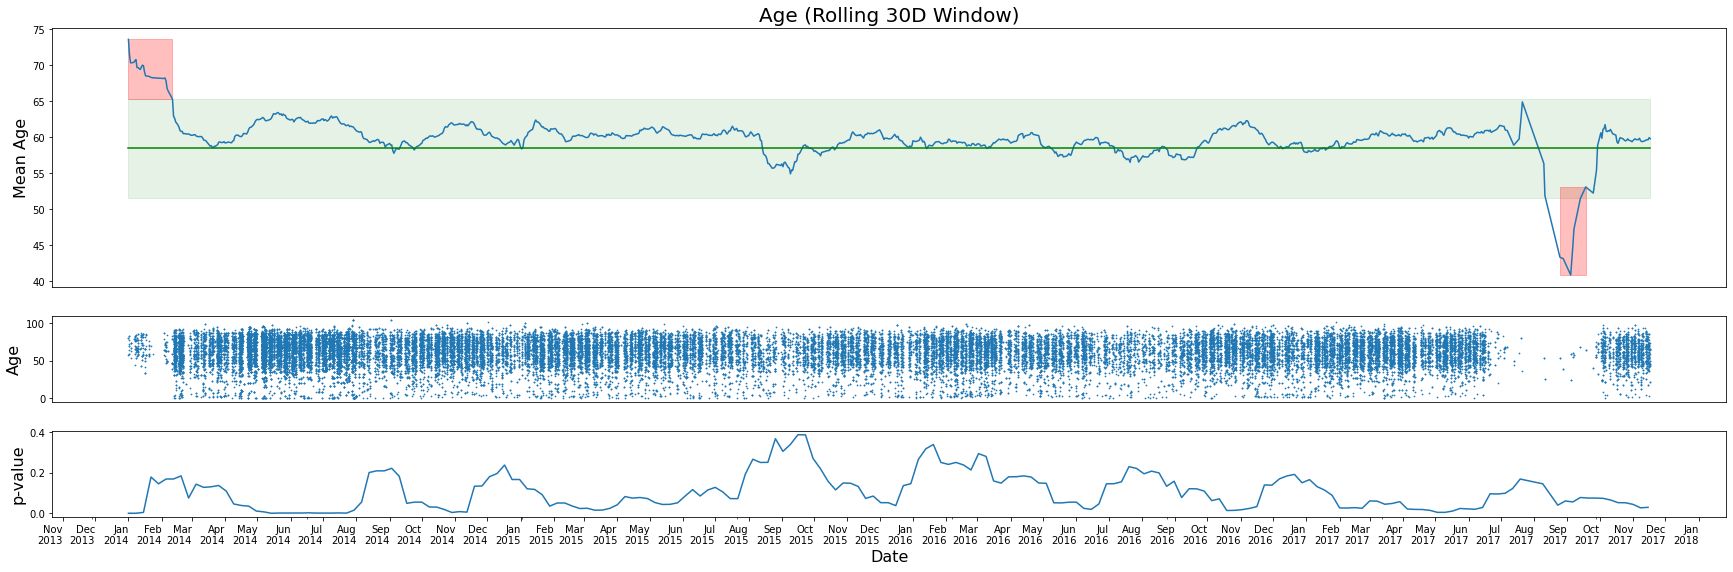

In [4]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(30, 10),
    sharex=True,
    gridspec_kw={"height_ratios": [15, 5, 5]},
)


df_roll.plot(ax=axes[0])
dfmean.plot(ax=axes[0], color="green")
axes[0].fill_between(
    dfstd.index, m + dfstd["H"], m + dfstd["L"], 3, color="green", alpha=0.1
)
for dfalert in alerts:
    _ = axes[0].fill_between(
        dfalert.index, dfalert["h"], dfalert["l"], 3, color="red", alpha=0.25
    )

axes[1].scatter(df_target.index.tolist(), df_target[col], marker=".", s=2)
df_roll_p.plot(ax=axes[2])

# Format Titles and ticks
verbose_column_nane = col.replace("_", " ").title()
axes[0].set_title(f"{verbose_column_nane} (Rolling {freq} Window)", fontsize=20)
axes[0].set_ylabel(f"Mean {verbose_column_nane}", fontsize=16)
axes[1].set_ylabel(f"{verbose_column_nane}", fontsize=16)

axes[0].get_legend().remove()

axes[0].axes.get_xaxis().set_visible(False)
axes[1].axes.get_xaxis().set_visible(False)

axes[-1].set_xlabel("Date", fontsize=16)
axes[-1].set_ylabel("p-value", fontsize=16)

# Create custom ticks using matplotlib date tick locator and formatter
loc = mdates.MonthLocator(interval=1)
axes[-1].xaxis.set_major_locator(loc)
fmt = mdates.DateFormatter("%b\n%Y")
axes[-1].xaxis.set_major_formatter(fmt)
plt.xticks(rotation=0, fontsize=10)
_ = plt.yticks(fontsize=10)


# Categorical Drift Analysis

In [5]:
# Load padchest CSV
padchest_csv = settings.PADCHEST_FILENAME
df = pd.read_csv(padchest_csv)
df = prepare_padchest(df)

view_dict = {
    "Frontal": ["POSTEROANTERIOR", "ANTEROPOSTERIOR", "PA", "AP"],
    "Lateral": ["LL", "LATERAL", "RL", "LLD"],
}
view_dict_rev = {vv: k for k, v in view_dict.items() for vv in v}
df["view"] = df["ViewPosition_DICOM"].apply(lambda x: view_dict_rev.get(x, "Other"))

df = df.set_index("StudyDate").sort_index()


In [6]:
# Define graph constants
col = "Manufacturer_DICOM"
col = "view"
freq = "30D"
resolution = "7d"
split_date = "2014-01-01"

# Encode column into numeric values
colc = col + "_codes"
df[col] = df[col].astype("category")
df[colc] = df[col].cat.codes

# Set index and split dataframe
df_ref = df.loc[(df.index < split_date)]
df_target = df[(df.index >= split_date)]

train_range = df_ref.index.min(), df_ref.index.max()
test_range = df_target.index.min(), df_target.index.max()

# Calculate Rolling statisics on target data
dfp = (
    df_target[col]
    .resample(resolution)
    .apply(lambda s: s.value_counts(normalize=True).sort_index())
    .unstack()
    .fillna(0)
    .rolling(freq)
    .mean()
)
dfp = dfp.div(dfp.sum(axis=1), axis=0)

# Calculate reference statistics
ref_stats = sorted(
    df_ref[col].value_counts(normalize=True).sort_index().to_dict().items(),
    key=lambda x: x[0],
)
(k, v), (_, v2) = zip(*([("StudyDate", df_target.index.min())] + ref_stats)), zip(
    *([("StudyDate", df_target.index.max())] + ref_stats)
)
dfmean = pd.DataFrame([v, v2], columns=k).set_index("StudyDate")

# Calculate mean rolling pvalue with stats calcuated at some resolution
df_rollp = (
    df_target[colc]
    .resample(resolution)
    .apply(lambda x: calc_p_categorical(df_ref[colc], x))
    .dropna()
    .rolling(freq)
    .mean()
)


## Plot Categorical Analysis

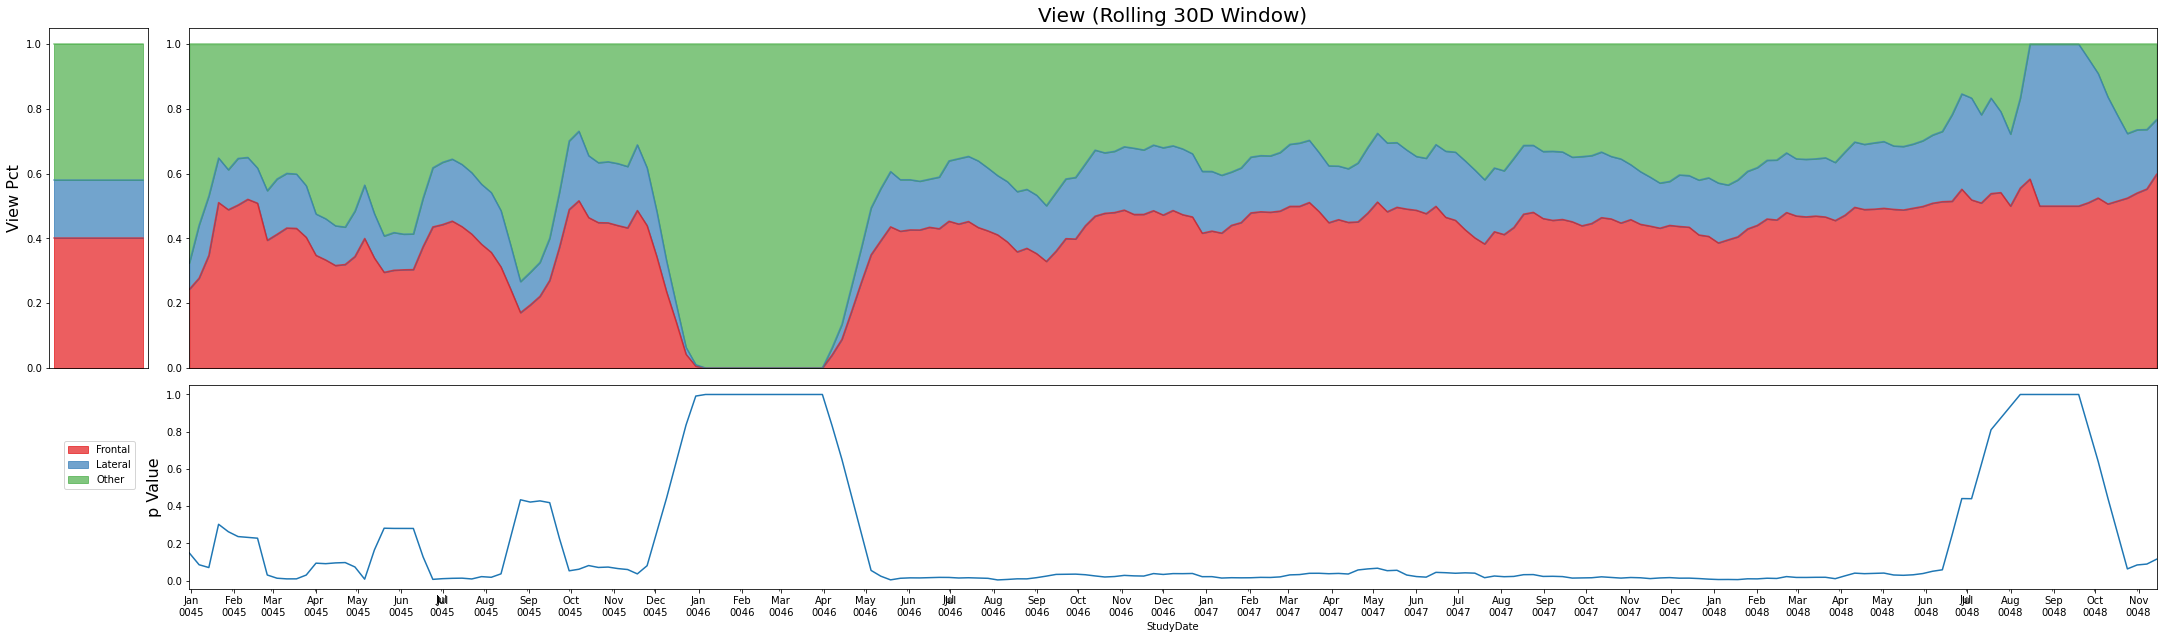

In [7]:
fig, axes_rows = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(30, 10),
    gridspec_kw={"width_ratios": [1, 20], "height_ratios": [5, 3]},
    sharey=False,
    sharex='col'
)
fig.tight_layout()

axes_rows[1][0].set_visible(False)

# Fix colors
cm = plt.get_cmap("Set1")
my_colors = cm(range(df[col].nunique()))
color_dict = dict(zip(sorted(df[col].unique()), my_colors))
dfp.columns = [str(c) for c in dfp.columns]
for c in color_dict:
    if c not in dfp:
        dfp[c] = 0

dfp = dfp[sorted(color_dict.keys())]
dfmean.columns = dfmean.columns.map(str)
dfmean = dfmean[sorted(color_dict.keys())]


dfmean.plot.area(ax=axes_rows[0][0], color=[color_dict[c] for c in dfmean], alpha=0.7)
dfp.plot.area(ax=axes_rows[0][1], color=[color_dict[c] for c in dfp], alpha=0.7)
df_rollp.plot(ax=axes_rows[1][1])

axes_rows[0][1].legend(bbox_to_anchor=(-0.025, -0.2), loc="bottom right")

verbose_column_nane = col.replace("_", " ").title()
axes_rows[0][1].set_title(f"{verbose_column_nane} (Rolling {freq} Window)", fontsize=20)

axes_rows[0][0].get_legend().remove()
axes_rows[0][0].axes.get_xaxis().set_visible(False)
axes_rows[0][1].axes.get_xaxis().set_visible(False)

axes_rows[0][0].set_ylabel(f"{verbose_column_nane} Pct", fontsize=16)
axes_rows[1][1].set_ylabel(f"p Value", fontsize=16)

# Create custom ticks using matplotlib date tick locator and formatter
loc = mdates.MonthLocator(interval=1)
axes_rows[-1][-1].xaxis.set_major_locator(loc)
fmt = mdates.DateFormatter("%b\n%Y")
axes_rows[-1][-1].xaxis.set_major_formatter(fmt)
plt.xticks(rotation=0, fontsize=10)
_ = plt.yticks(fontsize=10)
